In [2]:
# Copyright (c) Facebook, Inc. and its affiliates.
#
# This source code is licensed under the MIT license found in the
# LICENSE file in the root directory of this source tree.
from IPython.core.display import display, HTML

display(HTML("<style>.container { width:95% !important; }</style>"))
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import multiprocessing as mp
import os
from networkx.utils import py_random_state
import time

sns.set_context("poster")
sns.set_style("ticks")
current_palette = sns.color_palette('muted',n_colors=9)

np.set_printoptions(linewidth=200)



def compute_count(channel, group):
    divide = channel//group
    remain = channel%group

    out = np.zeros(group, dtype=int)
    out[:remain]=divide+1
    out[remain:]=divide
    return out

@py_random_state(3)
def ws_graph(n, k, p, seed=1):
    """Returns a ws-flex graph, k can be real number in [2,n]
    """
    assert k>=2 and k<=n
    # compute number of edges:
    edge_num = int(round(k*n/2))
    count = compute_count(edge_num, n)
    # print(count)
    G = nx.Graph()
    for i in range(n):
        source = [i]*count[i]
        target = range(i+1,i+count[i]+1)
        target = [node%n for node in target]
        # print(source, target)
        G.add_edges_from(zip(source, target))
    # rewire edges from each node
    nodes = list(G.nodes())
    for i in range(n):
        u = i
        target = range(i+1,i+count[i]+1)
        target = [node%n for node in target]
        for v in target:
            if seed.random() < p:
                w = seed.choice(nodes)
                # Enforce no self-loops or multiple edges
                while w == u or G.has_edge(u, w):
                    w = seed.choice(nodes)
                    if G.degree(u) >= n - 1:
                        break  # skip this rewiring
                else:
                    G.remove_edge(u, v)
                    G.add_edge(u, w)
    return G

@py_random_state(4)
def connected_ws_graph(n, k, p, tries=100, seed=1):
    """Returns a connected ws-flex graph.
    """
    for i in range(tries):
        # seed is an RNG so should change sequence each call
        G = ws_graph(n, k, p, seed)
        if nx.is_connected(G):
            return G
    raise nx.NetworkXError('Maximum number of tries exceeded')


def compute_stats(G):
    G_cluster = sorted(list(nx.clustering(G).values()))
    cluster = sum(G_cluster) / len(G_cluster)
    # path
    path = nx.average_shortest_path_length(G)
    return cluster, path

def norm(x):
    ## to 0-1
    x = x-x.min()
    if x.max()==0:
        x[:]=0
    else:
        x = x/x.max()
    return x



def get_graph(n,degree,p,repeat=30):
    # row: repeat, column: n,degree,p,seed,cluster,path
    result = np.zeros((repeat, 6))
    for i in range(repeat):
        graph = connected_ws_graph(n=n, k=degree, p=p, seed=i)
        cluster, path = compute_stats(graph)
        result[i] = [n, degree, p, i, cluster, path]
    return result


### 16: 30, 200, 300
### 64: 30, 300, 300
def sweep_graphs(n, processes=4):
    print(n)
    t0 = time.time()
    pool = mp.Pool(processes=processes)
    deg_min = 4
    deg_max = n-2
    degree_range = np.square(np.linspace(np.sqrt(deg_min),np.sqrt(deg_max),200))
    p_range = np.linspace(0,1,300)**2

    args_all = [(n,degree,p) for degree in degree_range for p in p_range]
    results = [pool.apply_async(get_graph, args=args) for args in args_all]
    output = [p.get() for p in results]
    output = np.concatenate(output,axis=0)

    dir_out = 'graph_configs'
    if not os.path.isdir(dir_out):
        os.mkdir(dir_out)
    np.save('{}/all_n{}_final.npy'.format(dir_out,n),output)
    t1 = time.time()
    print('time: {}'.format(t1-t0))

In [ ]:
# Note: by default this will take ~1hr for 100-core cpu. 
# You can adjust the range of graph sweeping for faster performance
# We have provided the zipped output with this code repository: "graph_configs/all_n16_final.zip", "graph_configs/all_n64_final.zip"
# You can simply unzip the files to skip this code block

### Sweep WS-flex graph, 16 nodes
# sweep_graphs(16, processes=4)
### Sweep WS-flex graph, 64 nodes
# sweep_graphs(64, processes=4)


[64.          0.36550103  0.09883558  6.          0.57425391  1.64087302]
sparsity 0.12500000000000003 0.96875
clustering 0.07485743423243424 0.9845326174075556
path 1.0158730158730158 4.444444444444445
52
449
3942


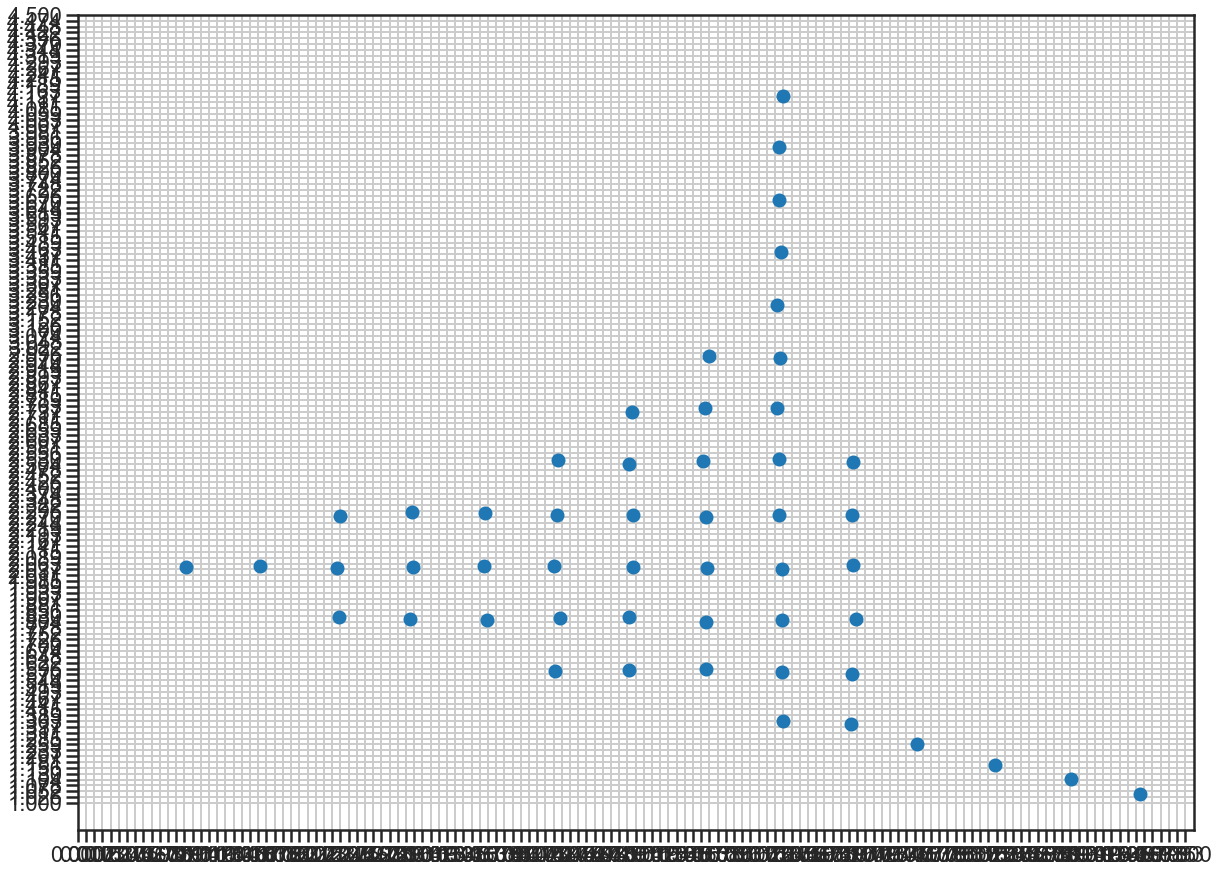

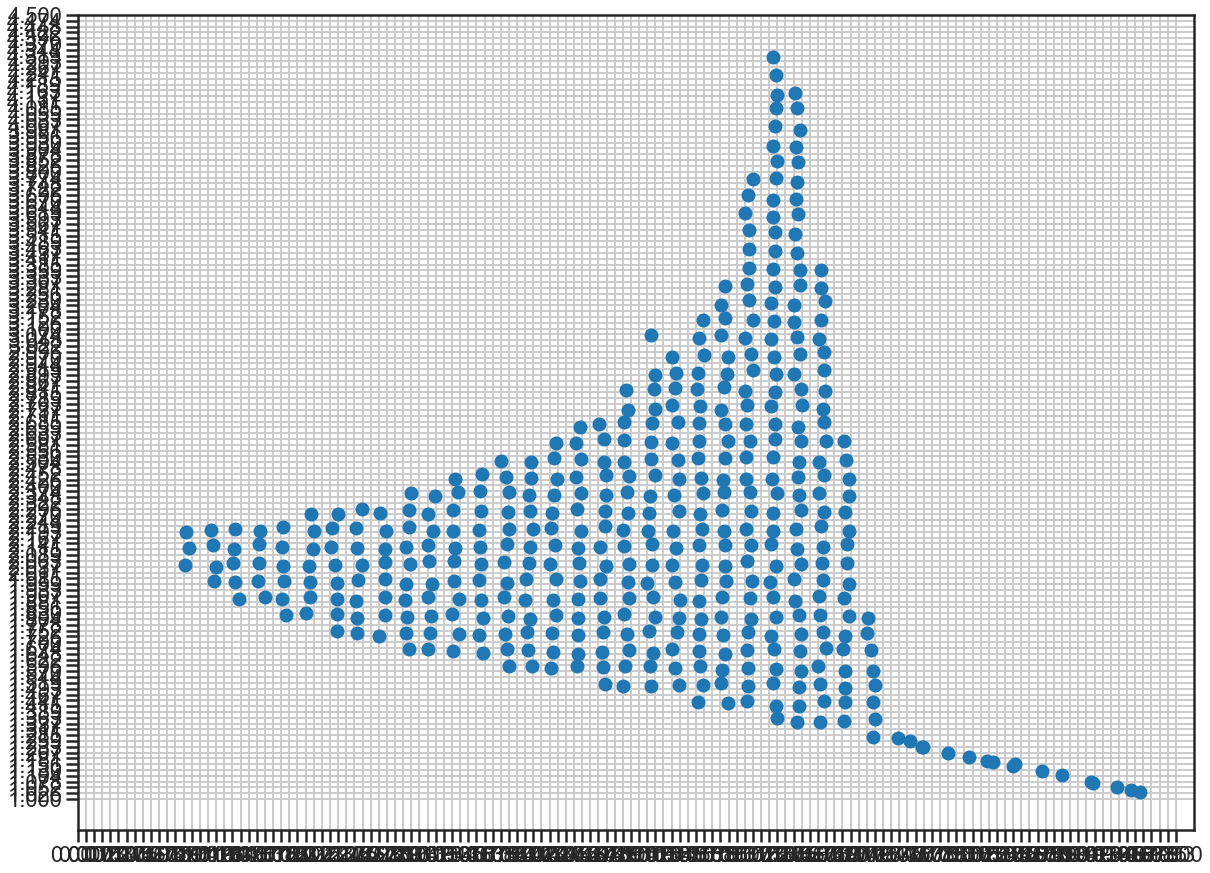

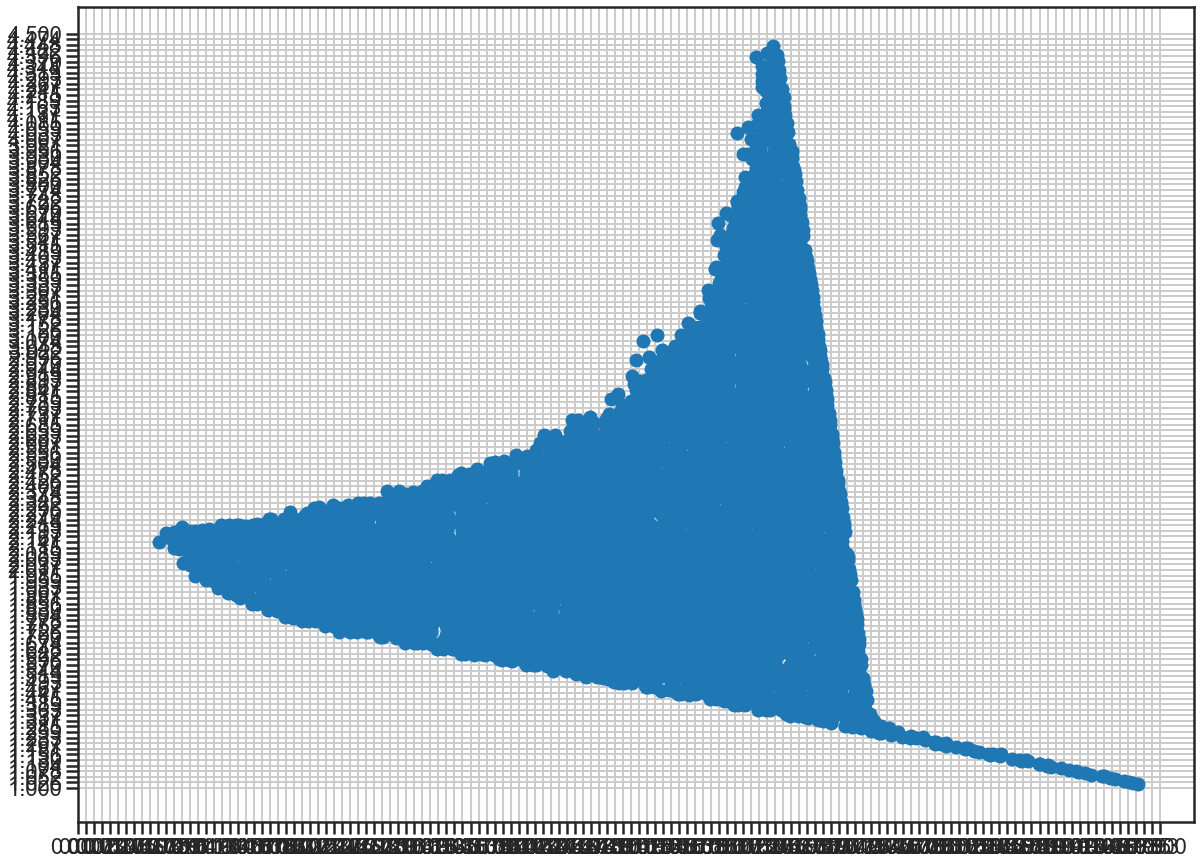

In [3]:
### Subsample WS-flex graphs

result = np.load('graph_configs/all_n64_final.npy')

# compute sparsity
result[:,1] = result[:,1]/result[:,0]
# filter too sparse graphs
result = result[result[:,1]>=0.125,:]
# shuffle
np.random.seed(1)
id_random = np.random.permutation(result.shape[0])
result_shuffle = result[id_random,:]

print(result_shuffle[0])
print('sparsity', result[:,1].min(), result[:,1].max())
print('clustering', result[:,-2].min(), result[:,-2].max())
print('path', result[:,-1].min(), result[:,-1].max())

bins_clustering = np.linspace(0,1,15*9+1) # clustering
bins_path = np.linspace(1,4.5,15*9+1) # path

digits_clustering = np.digitize(result_shuffle[:,-2],bins_clustering)
digits_path = np.digitize(result_shuffle[:,-1],bins_path)

thresh = 1
filter_1 = []
filter_2 = []
filter_3 = []
counts = np.zeros((len(bins_clustering)+1, len(bins_path)+1))
ids = np.ones((len(bins_clustering)+1, len(bins_path)+1),dtype=int)*-1
for i in range(len(result_shuffle)):
    if counts[digits_clustering[i], digits_path[i]]<thresh:
        ids[digits_clustering[i], digits_path[i]] = i
        counts[digits_clustering[i], digits_path[i]] += 1
        filter_3.append(i)
        if digits_clustering[i]%9==5 and digits_path[i]%9==5:
            filter_1.append(i)
        if digits_clustering[i]%9 in [2,5,8] and digits_path[i]%9 in [2,5,8]:
            filter_2.append(i)

for i in range(len(bins_clustering)+1):
    for j in range(len(bins_path)+1):
        if i%9==5 and j%9==5 and counts[i, j] == 0 and bins_clustering[i]>0.75:
            flag = False
            for m in range(i-1,i+2):
                if flag:
                    break
                for k in range(j-3,j+4):
                    if counts[m,k] != 0:
                        filter_1.append(ids[m,k])
                        filter_2.append(ids[m,k])
                        flag = True
                        break
            continue
        elif i%9 in [2,5,8] and j%9 in [2,5,8] and (not (i%9==5 and j%9==5)) and counts[i, j] == 0 and bins_clustering[i]>0.75:
            flag = False
            for m in range(i,i+1):
                if flag:
                    break
                for k in range(j-1,j+2):
                    if counts[m,k] != 0:
                        filter_2.append(ids[m,k])
                        flag = True
                        break
            
print(len(filter_1))
print(len(filter_2))
print(len(filter_3))

result_plot_1 = result_shuffle[filter_1]
result_plot_2 = result_shuffle[filter_2]
result_plot_3 = result_shuffle[filter_3]

for i in filter_1:
    assert i in filter_2
    assert i in filter_3
    
for i in filter_2:
    assert i in filter_3

plt.figure(figsize=(20,15))
plt.scatter(result_plot_1[:,-2],result_plot_1[:,-1])
plt.xticks(bins_clustering)
plt.yticks(bins_path)
plt.grid(True)

plt.figure(figsize=(20,15))
plt.scatter(result_plot_2[:,-2],result_plot_2[:,-1])
plt.xticks(bins_clustering)
plt.yticks(bins_path)
plt.grid(True)

plt.figure(figsize=(20,15))
plt.scatter(result_plot_3[:,-2],result_plot_3[:,-1])
plt.xticks(bins_clustering)
plt.yticks(bins_path)
plt.grid(True)

# # save
np.save('graphs_n64_52.npy',result_plot_1)
np.save('graphs_n64_449.npy',result_plot_2)
np.save('graphs_n64_3942.npy',result_plot_3)